**Select T4 GPU for runtime accelerator for faster results**

# Package installation(Ultralytics for YOLO)

In [ ]:
!pip install ultralytics

# Model training


1.   Upload the dataset on local colab storage as a zip and unzip to /content directory
2.   Upload the data.yaml file to /content/Dataset
3.   Import Yolo and train the model on yolov8n(nano)



In [ ]:
!unzip /content/Dataset-20250611T090804Z-1-001.zip -d /content/

In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO('yolov8n.pt')

results = model.train(
    data='/content/Dataset/data.yaml',
    epochs=50,
    imgsz=416,
    batch=16,
    device=0,
)

Summary of Training output

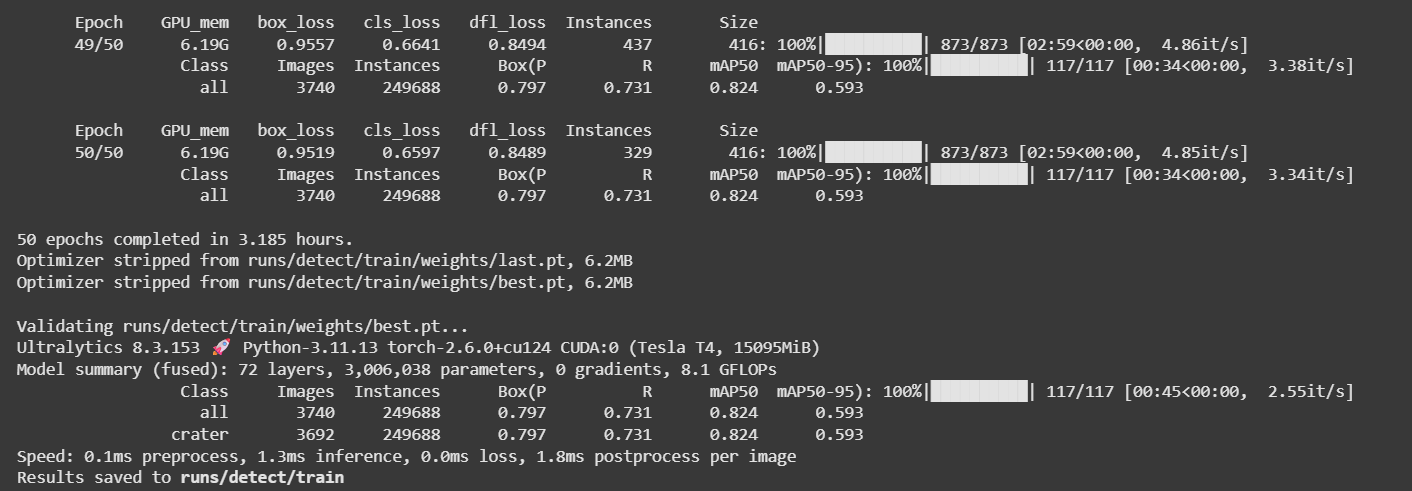

Saving the weights obtained from training

In [ ]:
from google.colab import files
files.download('/content/runs/detect/train/weights/best.pt')

# Model Evaluation

Made a custom evaluation function with outputs for random samples to judge the model

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
import os
from ultralytics import YOLO

# Load model
model = YOLO('/best.pt')

# Parameters
IOU_THRESHOLD = 0.5
CONFIDENCE_THRESHOLD = 0.323

# Compute IoU
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2
    xi1, yi1 = max(x1, x1g), max(y1, y1g)
    xi2, yi2 = min(x2, x2g), min(y2, y2g)
    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

# Load ground truth labels
def load_ground_truth(label_path, img_w, img_h):
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id, x_center, y_center, width, height = map(float, parts)
                x1 = int((x_center - width / 2) * img_w)
                y1 = int((y_center - height / 2) * img_h)
                x2 = int((x_center + width / 2) * img_w)
                y2 = int((y_center + height / 2) * img_h)
                boxes.append([x1, y1, x2, y2])
    return boxes

# Store history
precision_list, recall_list, accuracy_list = [], [], []

# Evaluate per image
def evaluate_and_plot(image_path, all_stats):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Run model prediction
    results = model(image_path, conf=CONFIDENCE_THRESHOLD)[0]
    pred_boxes = []
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        pred_boxes.append([x1, y1, x2, y2])
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 1)  # Red for predictions

    label_path = image_path.replace('images', 'labels').rsplit('.', 1)[0] + '.txt'
    gt_boxes = load_ground_truth(label_path, w, h) if os.path.exists(label_path) else []

    for (x1, y1, x2, y2) in gt_boxes:
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Green for ground truth

    matched_gt = set()
    TP, FP = 0, 0

    for pred in pred_boxes:
        matched = False
        for idx, gt in enumerate(gt_boxes):
            iou = compute_iou(pred, gt)
            if iou >= IOU_THRESHOLD and idx not in matched_gt:
                TP += 1
                matched_gt.add(idx)
                matched = True
                break
        if not matched:
            FP += 1

    FN = len(gt_boxes) - len(matched_gt)

    # Metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)

    all_stats['TP'] += TP
    all_stats['FP'] += FP
    all_stats['FN'] += FN
    all_stats['GT'] += len(gt_boxes)
    all_stats['PRED'] += len(pred_boxes)

    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title(f"GT: {len(gt_boxes)} | Pred: {len(pred_boxes)} | TP: {TP} | FP: {FP} | FN: {FN} | Acc: {accuracy*100:.1f}%")
    plt.axis('off')
    plt.show()


# Collect images
train_images = glob.glob('/content/Dataset/train/images/*.png')
valid_images = glob.glob('/content/Dataset/valid/images/*.png')


num_samples = 10
random_train_images = random.sample(train_images, min(num_samples, len(train_images)))
random_valid_images = random.sample(valid_images, min(num_samples, len(valid_images)))


all_stats = {'TP': 0, 'FP': 0, 'FN': 0, 'GT': 0, 'PRED': 0}

# Train evaluation
print("---- TRAIN IMAGES ----")
for img_path in random_train_images:
    evaluate_and_plot(img_path, all_stats)

# Validation evaluation
print("\n---- VALID IMAGES ----")
for img_path in random_valid_images:
    evaluate_and_plot(img_path, all_stats)

# Summary
final_precision = all_stats['TP'] / (all_stats['TP'] + all_stats['FP']) if (all_stats['TP'] + all_stats['FP']) > 0 else 0
final_recall = all_stats['TP'] / (all_stats['TP'] + all_stats['FN']) if (all_stats['TP'] + all_stats['FN']) > 0 else 0
f1 = 2 * final_precision * final_recall / (final_precision + final_recall) if (final_precision + final_recall) > 0 else 0
average_accuracy = np.mean(accuracy_list)

print("\n---- FINAL METRICS ----")
print(f"Total Ground Truth: {all_stats['GT']}")
print(f"Total Predictions: {all_stats['PRED']}")
print(f"TP: {all_stats['TP']} | FP: {all_stats['FP']} | FN: {all_stats['FN']}")
print(f"Precision: {final_precision:.3f}")
print(f"Recall: {final_recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Average Accuracy: {average_accuracy*100:.2f}%")

# Bar plot for GT vs Predictions
plt.figure(figsize=(6,5))
plt.bar(['Ground Truth','Predicted'], [all_stats['GT'], all_stats['PRED']], color=['green','red'])
plt.title("Total Boxes: Ground Truth vs Predicted")
plt.ylabel("Count")
plt.show()

# History plot for per image metrics
plt.figure(figsize=(10, 5))
plt.plot(precision_list, label='Precision', color='blue', marker='o')
plt.plot(recall_list, label='Recall', color='orange', marker='x')
plt.plot(accuracy_list, label='Accuracy', color='green', marker='*')
plt.title("Precision vs Recall vs Accuracy per image")
plt.xlabel("Image Index")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()


A sample

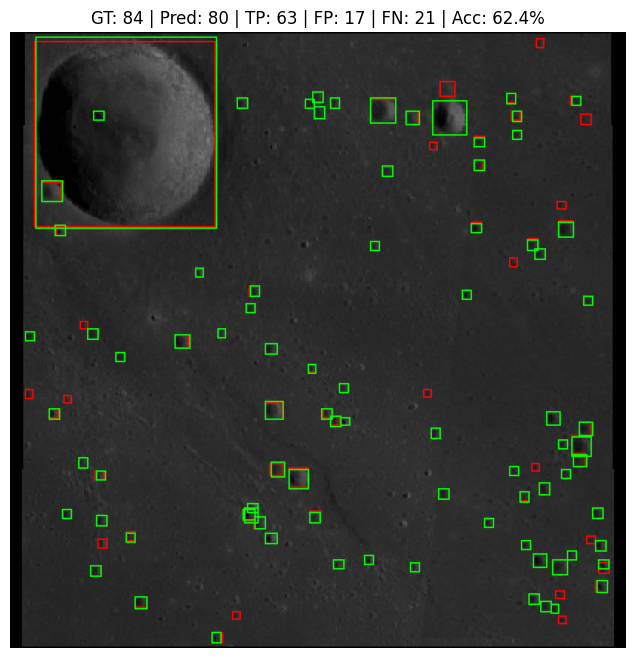

# Improving the Model(Transfer Learning)

To get better results, we tried to train the model again on previous weights but with a higher yolo model(yolov8m) with fewer epochs(20) so as to fine tune the weights further

In [ ]:
model = YOLO("yolov8m.yaml")  #previously used nano
model = model.load("/best_final.pt")    #load previous weights

In [ ]:
results = model.train(
    data="/data.yaml",
    epochs=20,
    imgsz=416,
    device="0",
    batch=16,
)

get the new updated weights and store them

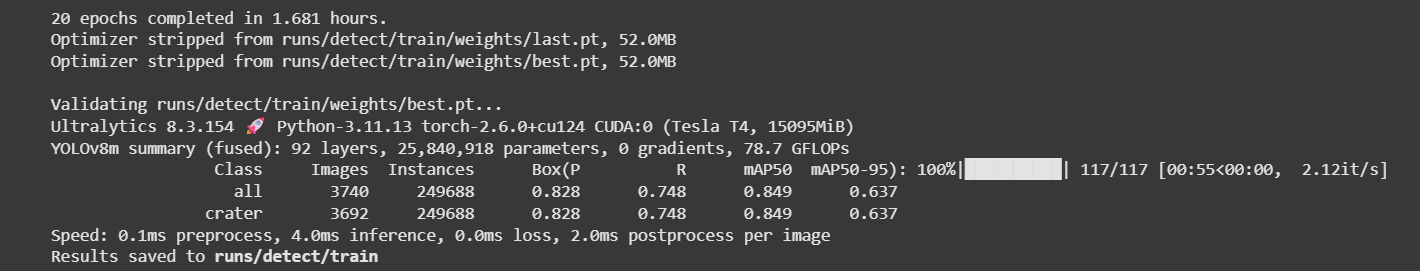

Results after upgrade

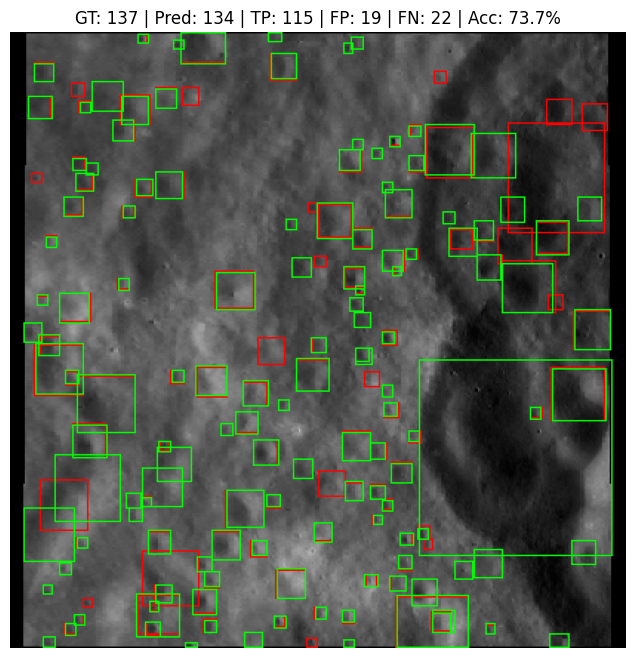

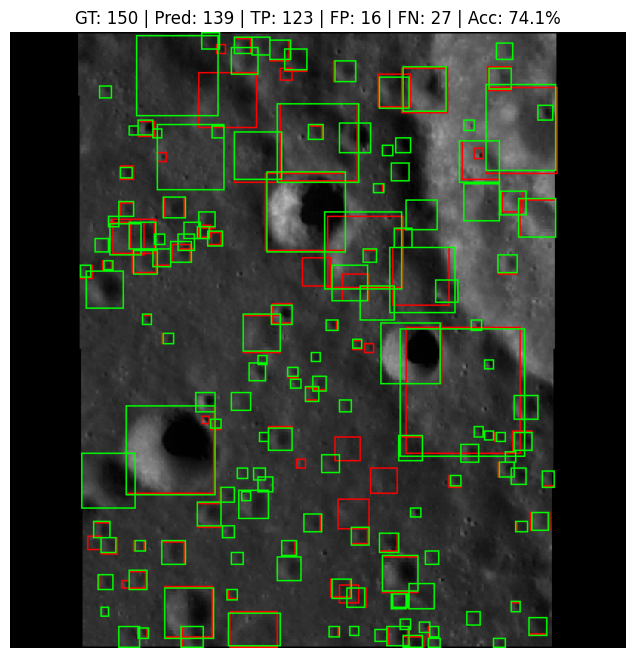

# Generating Test set labels

Upload the test images.zip on colab local storage and unzip to /content

(make sure to install ultralytics)

In [ ]:
!unzip /images.zip -d /content

In [ ]:
from ultralytics import YOLO

model = YOLO("/best _new.pt")

In [ ]:
import os


test_images = "/content/images"
output_dir = "/content/predictions"
os.makedirs(output_dir, exist_ok=True)


results = model.predict(source=test_images,
                        conf=0.323,
                        iou=0.5,
                        save=False, verbose=False)


for r in results:
    image_path = r.path
    filename = os.path.basename(image_path)
    name_no_ext = os.path.splitext(filename)[0]
    output_file = os.path.join(output_dir, f"{name_no_ext}_label.txt")

    with open(output_file, 'w') as f:
        for box in r.boxes:
            cls = int(box.cls[0])
            x, y, w, h = box.xywhn[0]
            f.write(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")


In [ ]:
import shutil

# Zip the folder
shutil.make_archive('/content/predictions', 'zip', '/content/predictions')

download the zip